In [1]:
# Import data operation and utilities libraries
import numpy as np
import pandas as pd
import warnings
import datetime as dt
import time
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler

from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

# Import visualization and analysis libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

%matplotlib inline

In [2]:
from collections import OrderedDict
import datetime as dt
import io
from google.colab import files

from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Deep Learning data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_input = pd.read_csv('/content/drive/MyDrive/Deep Learning data/ercot_raw.csv')
df_input.rename(columns = {'Hour Ending':'date', 'ERCOT':'usage'}, inplace = True)

df_input['date'] = pd.to_datetime(df_input['date'])

df_input['usage'] = pd.to_numeric(df_input['usage'])
df_input.set_index('date',inplace=True)

df_input.drop(index=df_input.index[-1], 
        axis=0, 
        inplace=True) #removing the last data point as it is 2020 data

In [4]:
df_daily = df_input.resample('D').apply(sum)
df_weekly = df_input.resample('W').apply(sum)

In [5]:
# Split train data and test data
train_size = round(len(df_daily)*0.678)

# train_data = df.WC.loc[:train_size] -----> it gives a series
# Do not forget use iloc to select a number of rows
train_data = df_daily.iloc[:train_size]
test_data = df_daily.iloc[train_size:]

In [6]:
scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [7]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
        
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train_scaled,30)
X_test, y_test = create_dataset(test_scaled,30)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (712, 30, 1)
y_train.shape:  (712, 1)
X_test.shape:  (323, 30, 1)
y_test.shape:  (323, 1)


In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [9]:
# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
  
model_bilstm = create_bilstm(64)

tf.random.set_seed(1234)

In [10]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 500,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop])
    return history

history_bilstm = fit_model(model_bilstm)

Epoch 1/500
36/36 [==============================] - 17s 93ms/step - loss: 0.0246 - val_loss: 0.0759
Epoch 2/500
36/36 [==============================] - 1s 36ms/step - loss: 0.0368 - val_loss: 0.0331
Epoch 3/500
36/36 [==============================] - 1s 36ms/step - loss: 0.0254 - val_loss: 0.0548
Epoch 4/500
36/36 [==============================] - 1s 36ms/step - loss: 0.0207 - val_loss: 0.0326
Epoch 5/500
36/36 [==============================] - 1s 36ms/step - loss: 0.0183 - val_loss: 0.0290
Epoch 6/500
36/36 [==============================] - 1s 36ms/step - loss: 0.0235 - val_loss: 0.0351
Epoch 7/500
36/36 [==============================] - 1s 36ms/step - loss: 0.0214 - val_loss: 0.0344
Epoch 8/500
36/36 [==============================] - 1s 36ms/step - loss: 0.0183 - val_loss: 0.0227
Epoch 9/500
36/36 [==============================] - 1s 36ms/step - loss: 0.0213 - val_loss: 0.0191
Epoch 10/500
36/36 [==============================] - 1s 35ms/step - loss: 0.0239 - val_loss: 0.025

In [11]:
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

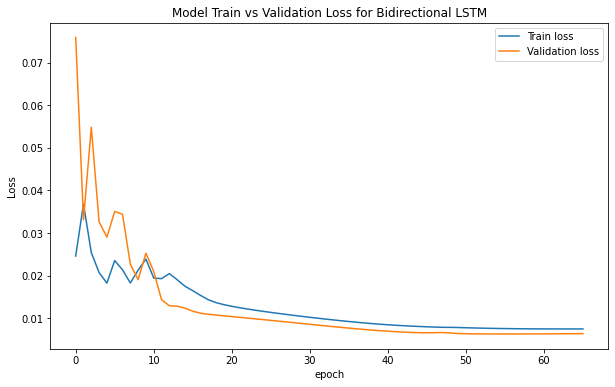

In [12]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_bilstm, 'Bidirectional LSTM')

In [13]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_bilstm = prediction(model_bilstm)

def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors/actual))*100

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.4f}'.format(mape))

evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')

Bidirectional LSTM:
Mean Absolute Error: 42528.9416
Root Mean Square Error: 57175.9384
Mean Absolute Percentage Error: 4.1667


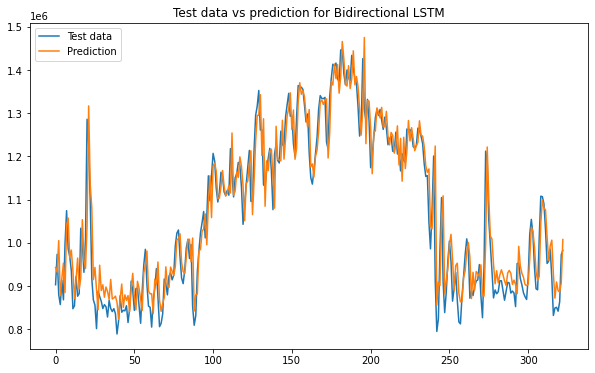

In [18]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
       
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)